In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import subprocess
import pyfmi
import os

import imp
import csv

In [2]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [3]:
from BuildingControlSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlSimulator.ControlModels.Deadband import Deadband

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
steps_per_hour = 60.
step_size = 3600. / steps_per_hour

In [14]:
idf = IDFPreprocessor(
    idf_name=f"Zone5VAV-Pri-SecLoop_{os.environ['ENERGYPLUS_INSTALL_VERSION']}.idf",
    weather_name="USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw",
    timesteps=steps_per_hour
)
idf.preprocess()
idf.make_fmu()

IDFPreprocessor loading .idf file: /root/home/lib/building-control-simulator/idf/v8-9-0/Zone5VAV-Pri-SecLoop_8-9-0.idf
Adding on-off set point control


'/root/home/lib/building-control-simulator/fmu/v8-9-0/Zone5VAV_Pri_SecLoop_8_9_0_prep.fmu'

In [16]:
idf.building_outputs

['FMU_Environment_Site_Outdoor_Air_Relative_Humidity',
 'FMU_Environment_Site_Outdoor_Air_Drybulb_Temperature']

In [7]:
# load .fmu with pyfmi

fmu_name = idf.fmu_name
print("Simulating FMU: {}".format(idf.fmu_path))
model = pyfmi.load_fmu(fmu=idf.fmu_path)
# config
output_fpath = os.path.join(os.environ["PACKAGE_DIR"], "data/output_simulation_loop.csv")
output_plot_fname = "co_simulation_output_{}.png".format(fmu_name.replace(".fmu", ""))

# config times (always in seconds unless specified)
# model must be initialized for multiples of 24 hours (1 day)
# this is the full durtation of the simulation, not step size
start_time = 60.0*60*(24*2)
init_final_time = 60.0*60*(24*10)
final_time = 60.0*60*(24*3)
intial_temp = 20.0

model.initialize(start_time, init_final_time)
print("Model Initialized")
t_step = start_time
# times = []
# step_return_status = []
# equip = []
# model.set('FMU_T_control_type', 1)
# model.set('FMU_T_cooling_stp', intial_temp)
# model.set('FMU_T_heating_stp', intial_temp)

#res = {k: [] for k in model.get_model_variables().keys()}


Simulating FMU: /root/home/lib/building-control-simulator/fmu/v8-9-0/Zone5VAV_Pri_SecLoop_8_9_0_prep.fmu


KeyboardInterrupt: 

In [8]:
model_keys = list(model.get_model_variables().keys())
row_keys = ["time_seconds", "step_status", "HVAC_mode", "stp_heat", "stp_cool"] + model_keys

In [9]:
stp_heat = 21.
stp_cool = 25.
deadband = 2.

In [8]:
from BuildingControlSimulator.ControlModels.Deadband import Deadband

In [9]:
Deadband(21)

TypeError: __init__() missing 7 required keyword-only arguments: 'FMU_control_cooling_stp_name', 'FMU_control_heating_stp_name', 'FMU_control_type_name', 'deadband', 'bm', 'stp_heat', and 'stp_cool'

In [10]:
t_ctrl_idx = row_keys.index("FMU_SPACE1-1_Zone_Air_Temperature")

In [11]:
print("_"*80)
print("Entering co-simulation loop")
print("_"*80)
# with open(output_fpath, "w") as csv_file:
#     writer = csv.writer(csv_file, delimiter=',')
#     writer.writerow(row_keys)

# res_df = pd.DataFrame(columns=col_keys)
rows = []
t_ctrl = intial_temp
HVAC_mode = 1
while t_step <= final_time:
#     if ( t_ctrl < (stp_heat - deadband) ) and HVAC_mode != 1:
#         # turn on heat
#         HVAC_mode = 1
#         model.set('FMU_T_cooling_stp', 99.0)  # cooling off
#         model.set('FMU_T_control_type', HVAC_mode)  # heating mode
#         model.set('FMU_T_heating_stp', 99.0)  # heating on
        
#     if t_ctrl > (stp_heat + deadband):
#         # turn off heat
#         HVAC_mode = 0
#         model.set('FMU_T_heating_stp', -60.0)  # heating off
#         model.set('FMU_T_cooling_stp', 99.0)  # cooling off
    
#     if t_ctrl > (stp_cool + deadband):
#         # turn on cool
#         HVAC_mode = 2
#         model.set('FMU_T_heating_stp', -60.0)  # heating off
#         model.set('FMU_T_control_type', HVAC_mode)  # cooling mode
#         model.set('FMU_T_cooling_stp', -60.0)  # cooling on
#     if t_ctrl < (stp_cool - deadband):
#         HVAC_mode = 0
#         model.set('FMU_T_heating_stp', -60.0)  # heating off
#         model.set('FMU_T_cooling_stp', 99.0)  # cooling off

    # do step
    step_status = (model.do_step(current_t=t_step, step_size=step_size, new_step=True))
    # save data as row
    row = [t_step, step_status, HVAC_mode, stp_heat, stp_cool] + [model.get(k)[0] for k in model_keys]
    rows.append(row)
    # TODO add multizone support
    t_ctrl = row[t_ctrl_idx]
    # step time forward
    t_step += step_size


# freeing the instance before script end seems to cause a segmentation fault
# model.free_instance()
# model.terminate()

print("="*80)
print("Simulation finished.")
print("="*80)

________________________________________________________________________________
Entering co-simulation loop
________________________________________________________________________________
Simulation finished.


In [12]:
df = pd.DataFrame.from_records(rows, columns=row_keys)

In [13]:
df["total_heat"] = (df["FMU_SPACE5-1_Zone_Air_System_Sensible_Heating_Rate"] 
                    + df["FMU_SPACE4-1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE3-1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE2-1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE1-1_Zone_Air_System_Sensible_Heating_Rate"])

In [14]:
df["total_internal_heat"] = (df["FMU_SPACE5-1_Zone_Total_Internal_Total_Heating_Rate"] 
                    + df["FMU_SPACE4-1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE3-1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE2-1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE1-1_Zone_Total_Internal_Total_Heating_Rate"])

In [17]:
row_keys

['time',
 'step_status',
 'HVAC_mode',
 'stp_heat',
 'stp_cool',
 'FMU_T_heating_stp',
 'FMU_T_cooling_stp',
 'FMU_T_control_type',
 'FMU_Environment_Site_Outdoor_Air_Relative_Humidity',
 'FMU_Environment_Site_Outdoor_Air_Drybulb_Temperature',
 'FMU_PLENUM-1_Zone_Air_Temperature',
 'FMU_PLENUM-1_Zone_Thermostat_Heating_Setpoint_Temperature',
 'FMU_PLENUM-1_Zone_Thermostat_Cooling_Setpoint_Temperature',
 'FMU_PLENUM-1_Zone_Air_System_Sensible_Heating_Rate',
 'FMU_PLENUM-1_Zone_Air_System_Sensible_Cooling_Rate',
 'FMU_PLENUM-1_Zone_Total_Internal_Total_Heating_Rate',
 'FMU_SPACE1-1_Zone_Air_Temperature',
 'FMU_SPACE1-1_Zone_Thermostat_Heating_Setpoint_Temperature',
 'FMU_SPACE1-1_Zone_Thermostat_Cooling_Setpoint_Temperature',
 'FMU_SPACE1-1_Zone_Air_System_Sensible_Heating_Rate',
 'FMU_SPACE1-1_Zone_Air_System_Sensible_Cooling_Rate',
 'FMU_SPACE1-1_Zone_Total_Internal_Total_Heating_Rate',
 'FMU_SPACE2-1_Zone_Air_Temperature',
 'FMU_SPACE2-1_Zone_Thermostat_Heating_Setpoint_Temperature',


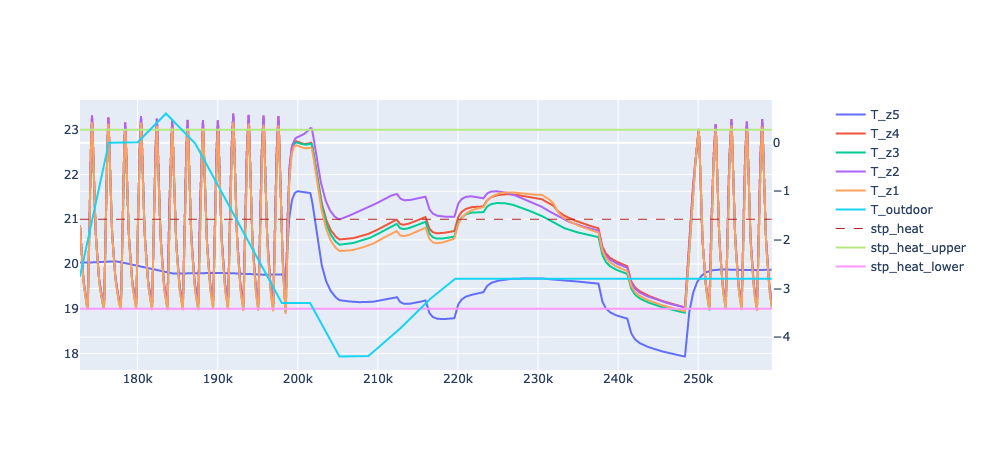

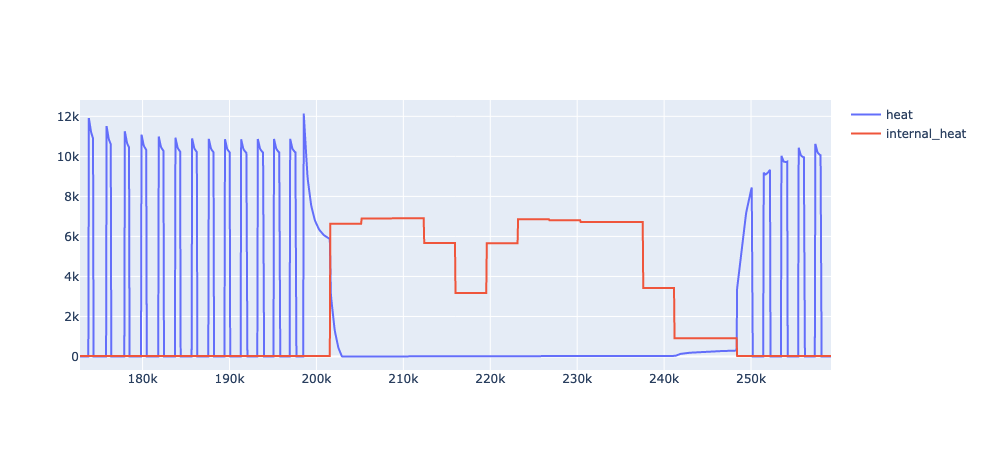

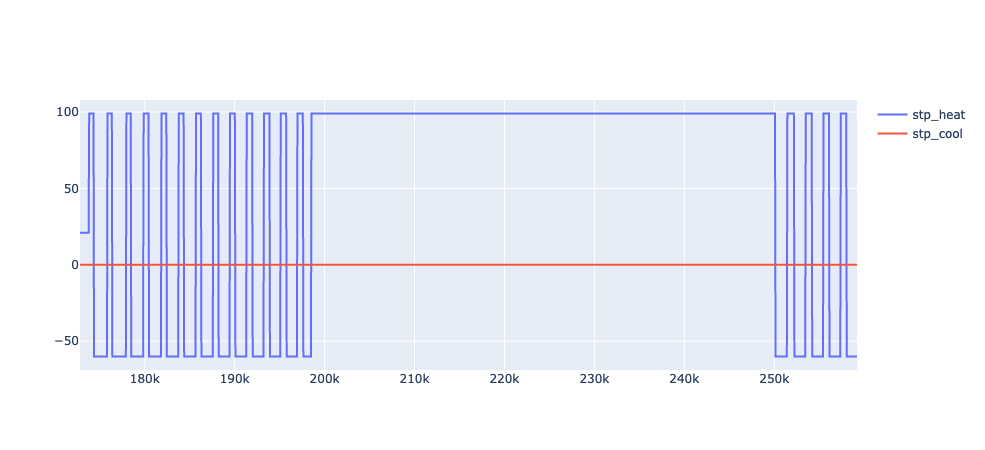

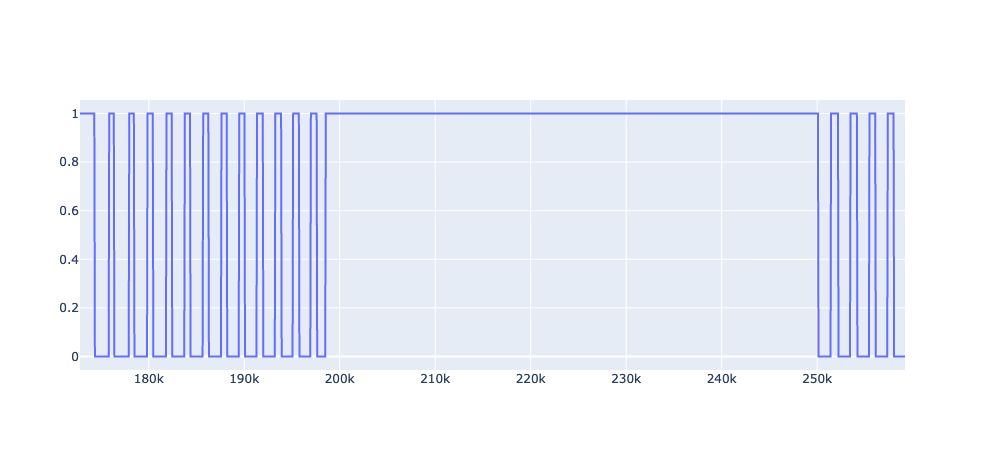

In [28]:
fig = plotly.subplots.make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df.time, y=df["FMU_SPACE5-1_Zone_Air_Temperature"], mode='lines',name='T_z5'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time, y=df["FMU_SPACE4-1_Zone_Air_Temperature"], mode='lines',name='T_z4'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time, y=df["FMU_SPACE3-1_Zone_Air_Temperature"], mode='lines',name='T_z3'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time, y=df["FMU_SPACE2-1_Zone_Air_Temperature"], mode='lines',name='T_z2'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time, y=df["FMU_SPACE1-1_Zone_Air_Temperature"], mode='lines',name='T_z1'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(
    x=df.time, y=df["FMU_Environment_Site_Outdoor_Air_Drybulb_Temperature"], mode='lines',name='T_outdoor')
              , row=1, col=1, secondary_y=True)

fig.add_trace(go.Scatter(x=df.time, y=df["stp_heat"],
                         mode='lines',
                         line=dict(color='firebrick', width=1,dash='dash'),
                         name='stp_heat'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time, y=df["stp_heat"] + deadband, mode='lines',name='stp_heat_upper'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time, y=df["stp_heat"] - deadband, mode='lines',name='stp_heat_lower'), row=1, col=1, secondary_y=False)
fig.show()

fig = plotly.subplots.make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df.time, y=df["total_heat"], mode='lines',name='heat'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.time, y=df["total_internal_heat"], mode='lines',name='internal_heat'), row=1, col=1)
fig.show()
fig = plotly.subplots.make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df.time, y=df["FMU_SPACE1-1_Zone_Thermostat_Heating_Setpoint_Temperature"], mode='lines',name='stp_heat'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.time, y=df["FMU_SPACE1-1_Zone_Thermostat_Cooling_Setpoint_Temperature"], mode='lines',name='stp_cool'), row=1, col=1)
fig.show()
fig = plotly.subplots.make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df.time, y=df["HVAC_mode"], mode='lines',name='HVAC_mode'), row=1, col=1)
fig.show()
# fig.update_layout(height=800, width=1000, title_text="Simulation results")

# TODO
fix the duplicated ThermostatSetpoint:SingleHeating in prep
add output var for ThermostatSetpoint:SingleHeating

In [13]:
opts = model.simulate_options()
opts['ncp'] = int((final_time) / (60. * 5))

opts['ncp']

864

In [14]:
res = model.simulate(final_time=final_time, options=opts)

Simulation interval    : 0.0 - 259200.0 seconds.
Elapsed simulation time: 0.5764751660001366 seconds.


In [ ]:
res.data_matrix.shape

In [ ]:
col_keys = model_keys.copy()
col_keys.insert(0, "time")

In [ ]:
for i in range(res.data_matrix.shape[0]):
    print(f"{i}: {res.data_matrix[i].any(0)}: {col_keys[i]}")

In [ ]:
res.data_matrix[9]

In [ ]:
res.data_matrix[11]